# Part 1 - Eigenfaces (5 Marks)

We will compute Eigenfaces - the PCA of human faces using Numpy and the funnelled “Labeled Faces in theWild” (LFW). Scikit learn Eigenfaces example is modified below to show how the PCA model of faces is constructed using Numpy arrays.
    
   First load the relevant data and functions

In [84]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf

In [85]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Extract the meaningful parameters of the faces dataset

In [86]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


It is important in machine learning to split the data accordingly into training and testing sets to avoid contamination of the model. Ideally, you should also have a validation set.

In [87]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

Compute the PCA via eigen-decomposition of the data matrix X after the mean of the training set is removed. This results in a model with variations from the mean. We also transform the training and testing data into ’face space’, i.e. the learned sub space of the eigen-faces.

### numpy version

In [5]:
# Center data
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test -= mean

#Eigen-decomposition
U, S, V = np.linalg.svd(X_train, full_matrices=False)
# print(U.shape, S.shape, V.shape)
components = V[:n_components]
# print(components.shape)
eigenfaces = components.reshape((n_components, h, w))

#project into PCA subspace
# numpy.ndarray.T Same as self.transpose().
X_transformed = np.dot(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)

(966, 150)
(322, 150)


### Tensorflow implementation

In [88]:
# Center data
mean = tf.math.reduce_mean(X_train, axis=0)
X_train -= mean
X_test -= mean

#Eigen-decomposition
# order of return tuple: numpy: u,s,vh   tensorflow: s,u,v
U, S, V = tf.linalg.svd(X_train, full_matrices=False)
U, S, V = S, U, tf.transpose(V)
# print(U.get_shape(), S.get_shape(), V.get_shape())
components = V[:n_components]
# print(components.get_shape())
eigenfaces = tf.reshape(components, [n_components, h, w])

#project into PCA subspace
X_transformed = tf.matmul(X_train, tf.transpose(components))
print(X_transformed.shape)
X_test_transformed = tf.matmul(X_test, tf.transpose(components))
print(X_test_transformed.shape)

(966, 150)
(322, 150)


Finally, plot the resulting eigen-vectors of the face PCA model, AKA the eigenfaces

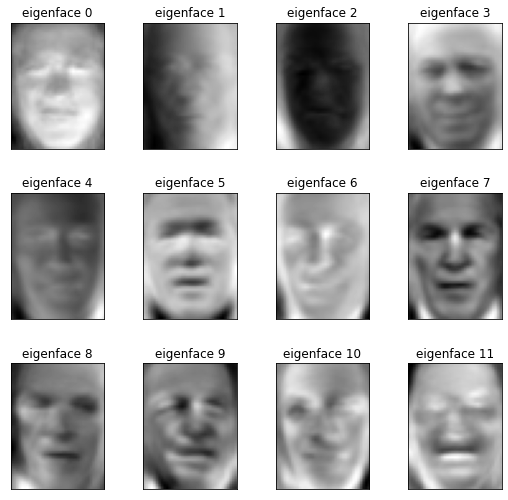

In [89]:
import matplotlib.pyplot as plt
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
#         plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
#         tensorflow version
        plt.imshow(tf.reshape(images[i], [h, w]), cmap=plt.cm.gray)
        
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

We should always evaluate the performance of the dimensionality reduction via a compactness plot

(966,)


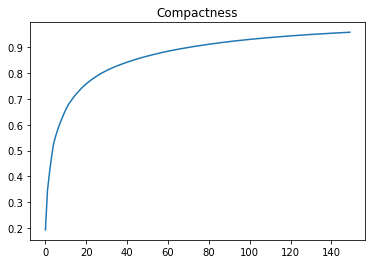

In [90]:
explained_variance = (S ** 2) / (n_samples - 1)
# total_var = explained_variance.sum()

# tensorflow version
total_var = tf.reduce_sum(explained_variance)

explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)

plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]
predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)

print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)

Total Testing 322
Predictions [3 3 6 3 3 3 3 1 3 3 3 6 3 3 3 3 4 3 3 4 1 1 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 1 3 1 3 1 3 3 3 3 4 3 3 3 3 3 3 2 1 3 6 3 1 1 6 6 6 4 1 4 1 3 4 6 3 3
 3 2 3 6 1 3 4 3 3 3 3 3 3 3 3 1 3 3 3 3 1 1 3 1 3 6 3 3 3 3 3 3 3 3 3 1 3
 3 3 3 3 3 1 4 1 3 1 3 3 1 3 4 5 3 1 3 6 6 6 3 3 4 3 3 1 3 1 3 3 1 3 3 1 3
 6 1 1 3 1 3 3 3 6 3 3 3 6 5 5 1 3 3 5 1 3 3 1 3 3 1 5 3 3 2 2 3 3 3 3 3 3
 3 3 3 3 2 4 3 2 3 4 3 3 3 3 6 3 3 3 4 3 3 6 2 3 2 1 5 6 3 3 5 3 2 3 3 5 3
 3 1 1 3 3 3 1 3 3 3 3 3 3 1 3 6 3 3 3 4 3 3 3 3 3 3 3 4 4 3 3 4 3 4 3 1 3
 3 3 3 3 1 3 4 6 1 3 1 6 1 3 3 3 3 3 3 3 3 1 1 3 3 3 3 3 3 3 4 3 3 5 3 3 3
 3 3 3 3 3 6 3 2 1 3 3 3 3 3 3 3 2 3 3 3 4 3 3 3 4 3]
Which Correct: [ True  True  True  True  True  True False  True  True  True  True False
  True False  True  True False  True  True  True  True False  True False
 False False False  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False  True
 False  T

In [9]:
print(classification_report(y_test, predictions, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.70      0.55      0.62        60
  Donald Rumsfeld       0.64      0.26      0.37        27
    George W Bush       0.63      0.90      0.74       146
Gerhard Schroeder       0.45      0.40      0.43        25
      Hugo Chavez       0.67      0.40      0.50        15
       Tony Blair       0.59      0.36      0.45        36

         accuracy                           0.62       322
        macro avg       0.53      0.41      0.44       322
     weighted avg       0.60      0.62      0.59       322



C:\Users\Daniel Zhang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Use the PCA ’face space’ as features and build a random forest classifier to classify the faces according to the labels. We then view its classification performance.

This should show you the performance of the RF/PCA based face recognition. (1 Marks) -not sure what mean

Your task for this part is to re-implement the above PCA algorithm of the Eigenfaces problem in TF using TF functions. (4 Marks) - done

# 2 Part 2 - CNNs (5 Marks)

In this part, you will create a CNN based classifier that should hopefully out perform the above Eigenfaces
algorithm from the previous part. Multiple layers will be strung together and tied to a fully connected (or dense) layers to result in a classified output.

  Using either TF or Keras, implement the following two CNN based classifiers for the same LFW dataset from Part 1:
    1. Dense only layers for classification. (1 Mark)
    2. Two convolution layers of 3x3 with 32 filters each and dense layers for classification. (1 Marks)
  You can reuse the initial elements of your code in Part 1 that loads and creates the training and the testing sets. You may use the Adam optimiser and (sparse) categorical cross entropy loss. Note that convolution layers expect 4D tensors so that you will need normalise and resize your arrays, see for example

In [91]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

### Question1

/ 255 means Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way:

In [92]:
#normalise
X_train = X_train / 255.0
X_test = X_test / 255.0
# CNN only 
# X_train = X_train[:, :, np.newaxis]
# X_test = X_test[:, :, np.newaxis]
print("X_train shape:", X_train.shape)

X_train shape: (966, 1850)


In [93]:
print("h: ", h)
print("w: ", w)

h:  50
w:  37


##### Dense only layers for classification
Layers extract representations from the data fed into them.
##### tf.keras.layers.Flatten:
transforms the format of the images from a two-dimensional array (of h by w pixels) to a one-dimensional array (of h * w = 1850 pixels). 
Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two
##### tf.keras.layers.Dense:
These are densely connected, or fully connected, neural layers. The first Dense layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

In [95]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(h, w)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 1850)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               236928    
_________________________________________________________________
dropout_30 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 10)                1290      
Total params: 238,218
Trainable params: 238,218
Non-trainable params: 0
_________________________________________________________________


### Question2

In [103]:
X = lfw_people.images

# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)

(966, 50, 37)


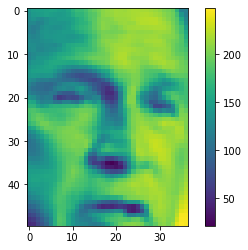

In [104]:
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

##### Two convolution layers of 3x3 with 32 filters each and dense layers for classification

In [105]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

#normalise
X_train = X_train / 255.0
X_test = X_test / 255.0
# CNN only 
X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]
print("X_train shape:", X_train.shape)

X_train shape: (966, 50, 37, 1)


In [106]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3),
    activation='relu', input_shape=(h, w, 1)), 
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3),
    activation='relu'),
  tf.keras.layers.Flatten(),
#     A Flatten layer in Keras reshapes the tensor to have a shape that is equal to the number of elements contained in the tensor.
  tf.keras.layers.Dense(units=120, activation='relu'),
  tf.keras.layers.Dense(units=84, activation='relu'),
  tf.keras.layers.Dense(units=10)
])

##### continue here
For each example the model returns a vector of "logits" or "log-odds" scores, one for each class.

In [107]:
predictions = model(X_train[:1]).numpy()
predictions

array([[-0.21686135, -0.02272974,  0.09934052,  0.08006777,  0.11267699,
        -0.03041429,  0.06597087, -0.18400946,  0.05409642,  0.04111739]],
      dtype=float32)

##### Question1 only
The tf.nn.softmax function converts these logits to "probabilities" for each class:

In [97]:
tf.nn.softmax(predictions).numpy()

array([[0.06725932, 0.0915703 , 0.11664207, 0.13246949, 0.11412986,
        0.08911441, 0.13746013, 0.08475535, 0.05788392, 0.10871507]],
      dtype=float32)

##### Question1 only
The losses.SparseCategoricalCrossentropy loss takes a vector of logits and a True index and returns a scalar loss for each example.

In [108]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

This loss is equal to the negative log probability of the true class: It is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to -tf.log(1/10) ~= 2.3.

In [109]:
loss_fn(y_train[:1], predictions).numpy()

2.2282379

##### compile use the Adam optimiser
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:
##### Loss function:
- This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.

##### Optimizer :
- This is how the model is updated based on the data it sees and its loss function.

##### Metrics:
- Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [110]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

##### Train the model
Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the X_train and y_train arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the test_images array.
4. Verify that the predictions match the labels from the test_labels array.

##### Feed the model
To start training, call the model.fit method—so called because it "fits" the model to the training data:

In [111]:
# The Model.fit method adjusts the model parameters to minimize the loss:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
31/31 [==============================] - 3s 89ms/step - loss: 1.8217 - accuracy: 0.3923
Epoch 2/5
31/31 [==============================] - 3s 93ms/step - loss: 1.4950 - accuracy: 0.4783
Epoch 3/5
31/31 [==============================] - 3s 93ms/step - loss: 1.1083 - accuracy: 0.6118
Epoch 4/5
31/31 [==============================] - 3s 93ms/step - loss: 0.6511 - accuracy: 0.7826
Epoch 5/5
31/31 [==============================] - 3s 93ms/step - loss: 0.3959 - accuracy: 0.8727


In [112]:
# The Model.evaluate method checks the models performance, 
model.evaluate(X_test,  y_test, verbose=2)

11/11 - 0s - loss: 0.6134 - accuracy: 0.8043


[0.6134414076805115, 0.804347813129425]

##### overfitting happens here
It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents overfitting. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:

##### Make predictions
With the model trained, you can use it to make predictions about some images. The model's linear outputs, logits. Attach a softmax layer to convert the logits to probabilities, which are easier to interpret.

In [27]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [28]:
probability_model(X_test[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[1.5216778e-05, 8.2719407e-06, 1.0224350e-04, 9.9871719e-01,
        4.6382243e-05, 6.1116938e-05, 1.0495431e-03, 3.6302690e-11,
        2.6484168e-09, 2.2598032e-10],
       [1.3196859e-01, 7.0445791e-02, 4.0060496e-03, 7.8103536e-01,
        6.6610947e-03, 2.6893320e-03, 3.1926346e-03, 2.4340881e-08,
        1.0889519e-06, 1.4983687e-08],
       [5.1783710e-03, 4.7014495e-03, 1.3556462e-02, 1.7934576e-02,
        1.3493137e-02, 7.8595191e-04, 9.4434881e-01, 2.7119448e-08,
        7.9612727e-07, 4.1984580e-07],
       [2.1194410e-05, 8.9001223e-05, 3.8464169e-04, 9.9185842e-01,
        3.0220228e-03, 3.4025167e-03, 1.2219518e-03, 2.0248576e-08,
        7.2232304e-08, 5.2958690e-08],
       [3.1971755e-03, 1.7249673e-03, 3.9338944e-03, 9.7189450e-01,
        1.3016534e-02, 1.0775824e-03, 5.1549920e-03, 1.2206478e-08,
        3.5788142e-07, 1.2942948e-08]], dtype=float32)>

### Question3

Finally, implement the classification of the CIFAR10 dataset using either TF or Keras. You should use at least 3 convolutional layers in your CNN based classifier. You should show loss and accuracy curves of the training of your classification method. You should use proper training, testing and validation
datasets and your validational accuracy should reach around 0.8. Usage of pre-built models will generally not be allowed unless approved by the demonstrator. (3 Marks)

The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [113]:
# baseline model with dropout on the cifar10 dataset
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD

In [114]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

trainX, trainY, testX, testY = load_dataset()

In [115]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

trainX, testX = prep_pixels(trainX, testX)

##### Create the convolutional base (a stack of Conv2D and MaxPooling2D layers.)
Each layer will use the ReLU activation function and the He weight initialization, which are generally best practices.

He uniform variance scaling initializer.
It draws samples from a uniform distribution within [-limit, limit] where the limit is sqrt(6 / fan_in) where fan_in is the number of input units in the weight tensor.
- He initialization works better for layers with ReLu activation.

In [116]:
# define cnn model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 64)        

Above, you can see that the output of every 2 Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

##### Add Dense layers on top
To complete our model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 128)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. 

First, you will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs and a softmax activation.

In [117]:
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 64)        

As you can see, our (4, 4, 128) outputs were flattened into vectors of shape (2048) before going through two Dense layers.

##### Compile and train the model

In [118]:
# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
# fit model
history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY))

Epoch 1/100
782/782 [==============================] - 159s 203ms/step - loss: 2.0243 - accuracy: 0.2513 - val_loss: 1.7477 - val_accuracy: 0.3568
Epoch 2/100
782/782 [==============================] - 159s 203ms/step - loss: 1.7103 - accuracy: 0.3673 - val_loss: 1.5629 - val_accuracy: 0.4295
Epoch 3/100
782/782 [==============================] - 160s 205ms/step - loss: 1.5871 - accuracy: 0.4190 - val_loss: 1.4577 - val_accuracy: 0.4727
Epoch 4/100
782/782 [==============================] - 152s 194ms/step - loss: 1.4893 - accuracy: 0.4563 - val_loss: 1.3747 - val_accuracy: 0.4978
Epoch 5/100
782/782 [==============================] - 154s 197ms/step - loss: 1.4190 - accuracy: 0.4791 - val_loss: 1.2849 - val_accuracy: 0.5427
Epoch 6/100
782/782 [==============================] - 160s 205ms/step - loss: 1.3467 - accuracy: 0.5117 - val_loss: 1.2339 - val_accuracy: 0.5573
Epoch 7/100
782/782 [==============================] - 161s 205ms/step - loss: 1.2870 - accuracy: 0.5328 - val_loss: 1

782/782 [==============================] - 151s 194ms/step - loss: 0.4351 - accuracy: 0.8447 - val_loss: 0.5634 - val_accuracy: 0.8090
Epoch 57/100
782/782 [==============================] - 152s 195ms/step - loss: 0.4336 - accuracy: 0.8451 - val_loss: 0.5557 - val_accuracy: 0.8119
Epoch 58/100
782/782 [==============================] - 889s 1s/step - loss: 0.4262 - accuracy: 0.8497 - val_loss: 0.5465 - val_accuracy: 0.8153
Epoch 59/100
782/782 [==============================] - 190s 243ms/step - loss: 0.4189 - accuracy: 0.8507 - val_loss: 0.5462 - val_accuracy: 0.8150
Epoch 60/100
782/782 [==============================] - 189s 241ms/step - loss: 0.4148 - accuracy: 0.8535 - val_loss: 0.5530 - val_accuracy: 0.8135
Epoch 61/100
782/782 [==============================] - 156s 199ms/step - loss: 0.4089 - accuracy: 0.8545 - val_loss: 0.5425 - val_accuracy: 0.8182
Epoch 62/100
782/782 [==============================] - 151s 193ms/step - loss: 0.3999 - accuracy: 0.8568 - val_loss: 0.5611 - v

##### Evaluate the model
show loss and accuracy curves of the training of the classification method

In [81]:
# evaluate model
_, acc = model.evaluate(testX, testY, verbose=0)
print('> %.3f' % (acc * 100.0))

> 82.440


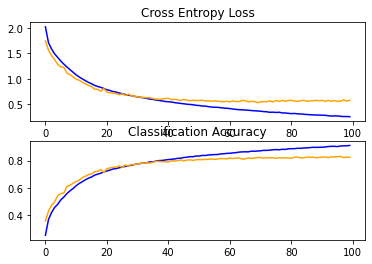

In [83]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.show()
    pyplot.close()

summarize_diagnostics(history)

# 3 Part 3 - Recognition (10 Marks)
For this part, you will need to develop your own solution to one of the recognition problems provided.There are two problems provided, each having a different level of difficulty and will ultimately affect the total maximum mark attainable for this section.
    Solve one of the following problems using TF or Keras, noting that the marks are allocated according to the level of difficulty:
    1. UNet based magnetic resonance (MR) image segmentation of the brain via the Preprocessed OASIS dataset - Hard Difficulty (Maximum 8 Marks out of 10)
    2. Face generation using generative adversarial networks (GANs) of the CelebA dataset - Very Hard Difficulty (Maximum 10 Marks out of 10)

You must obtain reasonable results and be able to explain all results, network layers and code to the demonstrator in order to obtain the marks available. Usage of pre-built models will generally not be allowed unless approved by the demonstrator. A note of warning, GANs have very chaotic convergence and therefore difficult to train, only attempt it if you have had some previous experience in deep learning and if you do, you do so at your own risk.

NO CLUE?:  go https://www.tensorflow.org/tutorials/images/cnn

### Face generation using generative adversarial networks (GANs) of the CelebA dataset 生成对抗网络

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

https://github.com/antonio-f/DeepLearning_Project5-GAN-face-generation/blob/master/Project5_DLND_face_generation/dlnd_face_generation.ipynb